# Further pushing it
This notebook is part of my Mercedes-Benz Kaggle efforts. Competion @: https://www.kaggle.com/c/mercedes-benz-greener-manufacturing Use of data subject to conditions mentioned in above link.<br>
As noted on the discussion forum, the features X118, X127 and X238 can be used to determine the affiliation of the Dataset to the y-value distribution peak. (see visual below at "some plots")<br>

## With clustering of the data:
X127 = 1: peak @ 90
X127 = 0 and X118 = 1: peak @ 107
X127 = 0 and X118 = 0 and X238 = 1: peak @ 100
X127 = 0 and X118 = 0 and X238 = 0: peak @ 76

## With dropping of data:
This notebook drops X5, X4

## No manufactured data:
Not utilize the manufactured data approach: It causes overfitting, as only datasets with rowcount > 1 are manipulated, which means that all with rowcount = 1 are preserved.

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import string
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

## 1. Load Data Sets

In [2]:
df_train = pd.read_csv('../data/train.csv', index_col = 'ID').fillna(0)
df_train = df_train[df_train['y'] < 200] # drop one outlier data
df_test = pd.read_csv('../data/test.csv', index_col = 'ID').fillna(0)
li_del_columns = []

## 2. Construct additional features and change letter categorical to binary

In [3]:
def my_dummies(c, df1, df2):
    l = len(df1)
    df = pd.concat([df1, df2], axis = 0)
    df_temp = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df_temp, df], axis = 1)
    df = df.drop(c, axis = 1)
    df1 = df[ : l].copy()
    df2 = df[l : ].copy()
    return df1, df2

In [4]:
li_columnNames = [e for e in list(df_train.columns.values) if e not in {'y', 'X0', 'X1', 'X2', 'X3', 'X6', 'X8'}]
li_categorical = ['X0', 'X1', 'X2', 'X3', 'X6', 'X8']
li_drop = ['X4', 'X5']

df_train_eng = df_train.copy()
df_test_eng = df_test.copy()
df_train_eng.drop(li_drop, axis=1, inplace = True)
df_test_eng.drop(li_drop, axis=1, inplace=True)
li_columnNames = [e for e in li_columnNames if e not in li_drop]
df_train_eng['qty_options'] = df_train_eng[li_columnNames].sum(axis=1)
df_test_eng['qty_options'] = df_test_eng[li_columnNames].sum(axis=1)

for c in li_categorical:
    df_train_eng, df_test_eng = my_dummies(c, df_train_eng, df_test_eng)

## 3. some data clensing / Identifying data for possible clensing
### Identify duplicate columns

In [5]:
all_data = pd.concat((df_train_eng, df_test_eng))

c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_duplicates = []
for i in range(len(c)-1):
    v = all_data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_duplicates.append(c[j])
            print(' Column %s is identical to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_duplicates = list(set(li_duplicates))
print '\n Number of identified duplicates marked: %s' % len(li_duplicates)


 Number of columns before cleaning: 544
 Column X2_a is identical to X32. Removing X32
 Column X2_ac is identical to X125. Removing X125
 Column X2_ac is identical to X227. Removing X227
 Column X2_ad is identical to X107. Removing X107
 Column X2_ag is identical to X30. Removing X30
 Column X2_ai is identical to X215. Removing X215
 Column X2_am is identical to X260. Removing X260
 Column X2_ap is identical to X16. Removing X16
 Column X2_aq is identical to X211. Removing X211
 Column X2_as is identical to X251. Removing X251
 Column X2_at is identical to X184. Removing X184
 Column X2_at is identical to X262. Removing X262
 Column X2_au is identical to X59. Removing X59
 Column X2_aw is identical to X213. Removing X213
 Column X2_aw is identical to X67. Removing X67
 Column X2_b is identical to X26. Removing X26
 Column X2_d is identical to X97. Removing X97
 Column X2_f is identical to X23. Removing X23
 Column X2_g is identical to X112. Removing X112
 Column X2_g is identical to X

### Dropping duplicate columns
(yes there are columns duplicate and complimentary, so need to do it twice)

In [6]:
print 'Number columns before cleaning: ', df_train_eng.shape[1],
l = len(df_train_eng)
df = pd.concat([df_train_eng, df_test_eng], axis = 0)
for c in li_duplicates:
    df.drop(c, axis=1, inplace = True)

df_train_eng = df[ : l].copy()
df_test_eng = df[l : ].copy()
print 'and after cleaning: ', df_train_eng.shape[1]

Number columns before cleaning:  544 and after cleaning:  482


### Identify complementary columns

In [7]:
list_index = [e for e in list(df_train_eng.columns.values) if e not in {'y_actual', 'y', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8'}]
all_data = pd.concat((df_train_eng[list_index], df_test_eng[list_index]))
value_compliment = {0: 1, 1: 0}

# remove complimentary columns
c = all_data.columns
print('\n Number of columns before cleaning: %d' % len(c))
li_compliments = []
for i in range(len(c)-1):
    v = all_data[c[i]].replace(value_compliment).values
    for j in range(i+1,len(c)):
        if np.array_equal(v,all_data[c[j]].values):
            li_compliments.append(c[j])
            print(' Column %s is complimentary to %s. Removing %s' % (str(c[i]), str(c[j]), str(c[j])))
li_compliments = list(set(li_compliments))
print '\n Number of identified complements marked: %s' % len(li_compliments)


 Number of columns before cleaning: 481
 Column X128 is complimentary to X130. Removing X130
 Column X156 is complimentary to X157. Removing X157
 Column X204 is complimentary to X205. Removing X205
 Column X232 is complimentary to X263. Removing X263

 Number of identified complements marked: 4


### Droping complementary columns

In [8]:
print 'Number columns before cleaning: ', df_train_eng.shape[1],
l = len(df_train_eng)
df = pd.concat([df_train_eng, df_test_eng], axis = 0)
for c in li_compliments:
    df.drop(c, axis=1, inplace = True)

df_train_eng = df[ : l].copy()
df_test_eng = df[l : ].copy()
print 'and after cleaning: ', df_train_eng.shape[1]

Number columns before cleaning:  482 and after cleaning:  478


In [11]:
df_train_eng.to_csv(path_or_buf='../data/0709_train_eng.csv', index_label='ID', header=True)

In [12]:
df_test_eng.to_csv(path_or_buf='../data/0709_test_eng.csv', index_label='ID', header=True)

### Or just reload it:

In [14]:
df_train_eng = pd.read_csv('../data/0709_train_eng.csv', index_col='ID').fillna(0)

In [15]:
df_test_eng = pd.read_csv('../data/0709_test_eng.csv', index_col='ID').fillna(0)

## Let's split up the datasets for the subsets
The hirarchy (pseudo code):<br>
If X127 = 1 then peak 90<br>
else if X118 = 1 then peak = 107<br>
else if X238 = 1 then peak = 100<br>
else peak = 76

In [9]:
def slice_df(df, code):
    # expected values:
    #  df is the dataframe to be sliced,
    #  code is a list of integers with binary encoding (0 or 1) in the order for X127, X118, X238
    if code[0] == 1:
        return df[df['X127'] == 1]
    elif code[1] == 1:
        return df[((df['X127'] == 0) & (df['X118'] == 1))]
    elif code[2] == 1:
        return df[((df['X127'] == 0) & (df['X118'] == 0) & (df['X238'] == 1))]
    else:
        return df[((df['X127'] == 0) & (df['X118'] == 0) & (df['X238'] == 0))]
    

In [10]:
li_076 = [0,0,0]
li_090 = [1,0,0]
li_107 = [0,1,0]
li_100 = [0,0,1]

In [11]:
df_train_eng_076 = slice_df(df_train_eng, li_076)
df_train_eng_090 = slice_df(df_train_eng, li_090)
df_train_eng_100 = slice_df(df_train_eng, li_100)
df_train_eng_107 = slice_df(df_train_eng, li_107)
df_test_eng_076 = slice_df(df_test_eng, li_076)
df_test_eng_090 = slice_df(df_test_eng, li_090)
df_test_eng_100 = slice_df(df_test_eng, li_100)
df_test_eng_107 = slice_df(df_test_eng, li_107)

## Some graphs time:
### First one histogram for all y values

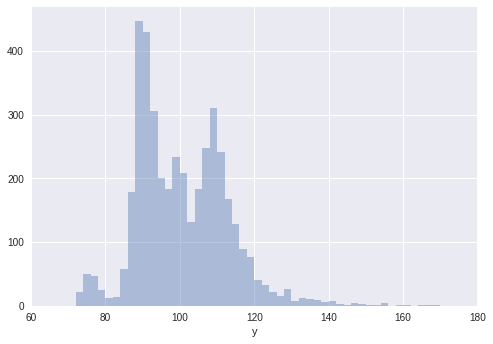

In [12]:
fig, ax = plt.subplots()
sns.distplot(df_train_eng['y'], bins=range(60,180,2), ax=ax, kde=False)
ax.set_xlim([60, 180])
plt.show()

### Then one histogram for the four distinct dataframes

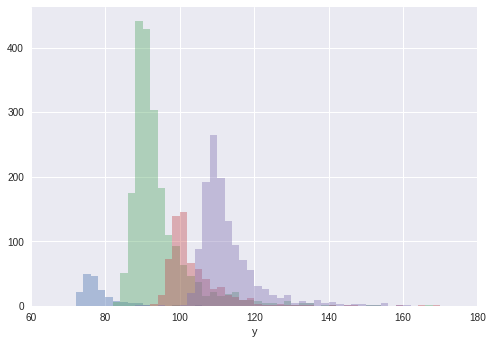

In [13]:
fig, ax = plt.subplots()
for a in [df_train_eng_076['y'], df_train_eng_090['y'], df_train_eng_100['y'], df_train_eng_107['y']]:
    sns.distplot(a, bins=range(60,180,2), ax=ax, kde=False)
ax.set_xlim([60, 180])
plt.show()

## Now for some model building:
I'll be using 70% of the artificial created data (train_cp) to train the individual models, the remaining 30% to evaluate the individual models and 100% of the original train data (train_eng) to validate the combination of the models. (There is at this time no second tier ML model to be trained to combine these models, so no train / test split of the originaa train data required)

In [14]:
li_all_test = [df_test_eng_076, df_test_eng_090, df_test_eng_100, df_test_eng_107]
li_all_train = [df_train_eng_076, df_train_eng_090, df_train_eng_100, df_train_eng_107]

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.10128, std: 0.06828, params: {'n_estimators': 48, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'max_depth': 1, 'min_child_weight': 3}, mean: -0.11225, std: 0.06809, params: {'n_estimators': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'max_depth': 1, 'min_child_weight': 3}, mean: -0.11237, std: 0.06516, params: {'n_estimators': 52, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'max_depth': 1, 'min_child_weight': 3}, mean: -0.08013, std: 0.04583, params: {'n_estimators': 48, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.07801, std: 0.05159, params: {'n_estimators': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.07728, std: 0.05101, params: {'n_estimators': 52, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.09329, std: 0.05190, params: {'n_estimators': 48, 'learning_rate': 0.1, 'colsample_bytree': 0.813, 'ma

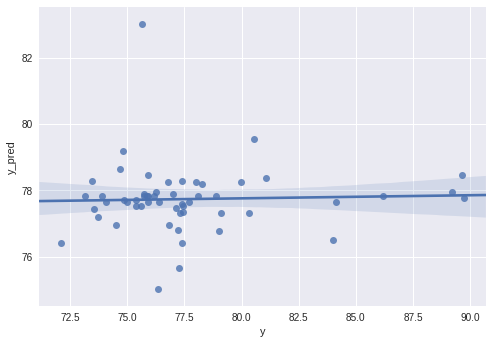

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.01345, std: 0.02085, params: {'n_estimators': 56, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth': 1, 'min_child_weight': 6}, mean: 0.01325, std: 0.02011, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth': 1, 'min_child_weight': 6}, mean: 0.01213, std: 0.01987, params: {'n_estimators': 64, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth': 1, 'min_child_weight': 6}, mean: 0.01332, std: 0.02095, params: {'n_estimators': 56, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth': 1, 'min_child_weight': 7}, mean: 0.01297, std: 0.02011, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth': 1, 'min_child_weight': 7}, mean: 0.01171, std: 0.01991, params: {'n_estimators': 64, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth': 1, 'min_child_weight': 7}, mean: 0.01230, std: 0.02090, params: {'n_estimators': 56, 'learning_rate': 0.1, 'colsample_bytree': 0.656, 'max_depth

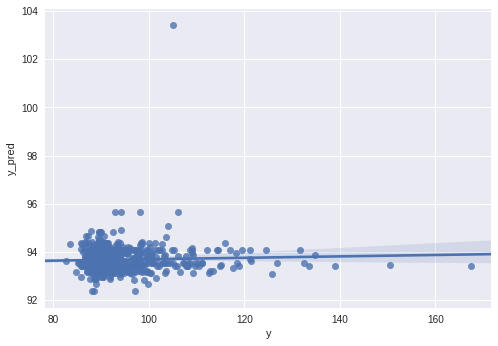

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.01853, std: 0.08599, params: {'n_estimators': 68, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 'min_child_weight': 1}, mean: 0.01772, std: 0.08747, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 'min_child_weight': 1}, mean: 0.01534, std: 0.08858, params: {'n_estimators': 72, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 'min_child_weight': 1}, mean: 0.02589, std: 0.09603, params: {'n_estimators': 68, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 'min_child_weight': 2}, mean: 0.02598, std: 0.09710, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 'min_child_weight': 2}, mean: 0.02269, std: 0.09651, params: {'n_estimators': 72, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.04876, std: 0.03224, params: {'n_estimators': 68, 'learning_rate': 0.1, 'colsample_bytree': 0.65, 'max_depth': 1, 

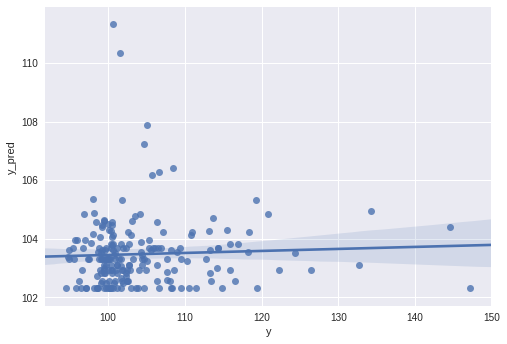

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.00593, std: 0.01669, params: {'n_estimators': 46, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_depth': 2, 'min_child_weight': 6}, mean: 0.00081, std: 0.01588, params: {'n_estimators': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_depth': 2, 'min_child_weight': 6}, mean: 0.00344, std: 0.01789, params: {'n_estimators': 54, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_depth': 2, 'min_child_weight': 6}, mean: -0.00903, std: 0.01429, params: {'n_estimators': 46, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_depth': 2, 'min_child_weight': 7}, mean: -0.00019, std: 0.01468, params: {'n_estimators': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_depth': 2, 'min_child_weight': 7}, mean: 0.00514, std: 0.01643, params: {'n_estimators': 54, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_depth': 2, 'min_child_weight': 7}, mean: -0.00848, std: 0.01421, params: {'n_estimators': 46, 'learning_rate': 0.1, 'colsample_bytree': 0.646, 'max_d

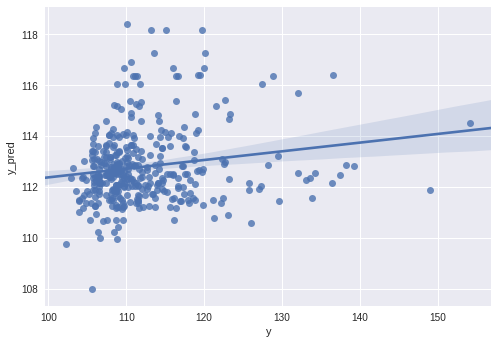

all:  0.578435617747


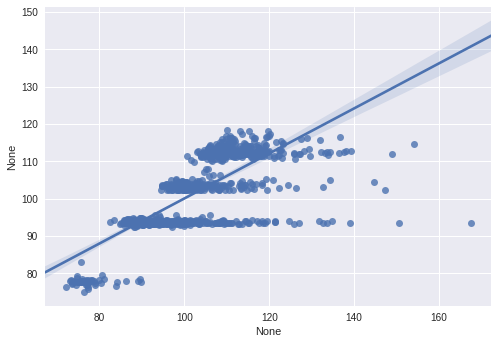

In [33]:
list_index = list(df_test_eng.columns.values)
li_remove = ['y']
for x in li_remove:
    list_index.remove(x)
list_test = list_index
list_train = ['y'] + list_test
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()

# list of parameters for each sub-set
cv_params_076 = {'max_depth': [1,2], 'learning_rate': [0.1], 'min_child_weight': [3,4,5], 'n_estimators': [48,50,52], 'colsample_bytree': [0.813, 0.815, 0.817]}
cv_params_090 = {'max_depth': [1,2], 'learning_rate': [0.1], 'min_child_weight': [6,7,8], 'n_estimators': [56,60,64], 'colsample_bytree': [0.656, 0.66, 0.664]}
cv_params_100 = {'max_depth': [1,2], 'learning_rate': [0.1], 'min_child_weight': [1,2,3], 'n_estimators': [68,70,72], 'colsample_bytree': [0.65, 0.655, 0.66]}
cv_params_107 = {'max_depth': [2,3,4], 'learning_rate': [0.1], 'min_child_weight': [6,7,8], 'n_estimators': [46,50,54], 'colsample_bytree': [0.646, 0.65, 0.654]}
ind_params_076 = {'seed':0, 'subsample': 0.8}
ind_params_090 = {'seed':0, 'subsample': 0.8}
ind_params_100 = {'seed':0, 'subsample': 0.8}
ind_params_107 = {'seed':0, 'subsample': 0.8}

cv_params = [cv_params_076, cv_params_090, cv_params_100, cv_params_107]
ind_params = [ind_params_076, ind_params_090, ind_params_100, ind_params_107]

for i in range(len(li_all_test)):
    df_X = li_all_train[i][list_train]
    df_Kaggle = li_all_test[i][list_test]
    df_y = df_X['y']
    df_X = df_X.drop('y', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=0)    

    model = GridSearchCV(xgb.XGBRegressor(**ind_params[i]), cv_params[i], scoring = 'r2', cv = 5) 
    model.fit(X_train, y_train)
    print model.grid_scores_
    #print model.cv_results_
    best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
    print(score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    y_pred = pd.Series(model.predict(X_test), name='y_pred', index=X_test.index)
    y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
    y_pred_all = y_pred_all.append(y_pred)
    y_test_all = y_test_all.append(y_test)
    df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
    y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
    print i, ': ', r2_score(y_test, y_pred)
    sns.regplot(y_test, y_pred)
    plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)
#output_Kaggle.to_csv(path='../data/20170618.2200.a_to_u_models.xgboost.csv', index_label='ID', header = True)

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.05922, std: 0.06515, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.06035, std: 0.07485, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.06544, std: 0.08129, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.06054, std: 0.07114, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.06034, std: 0.09032, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.06136, std: 0.08941, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.08519, std: 0.07979, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, '

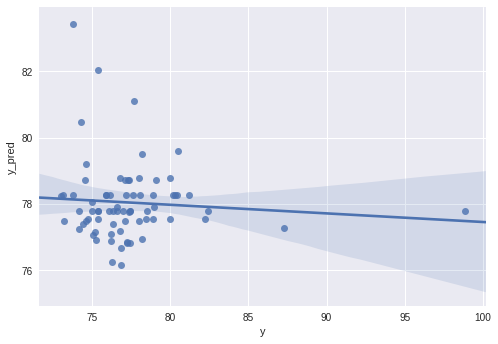

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.01129, std: 0.01536, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.01542, std: 0.01796, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.02026, std: 0.02315, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.00828, std: 0.01334, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.01142, std: 0.01807, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.01631, std: 0.02449, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.00925, std: 0.01807, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, '

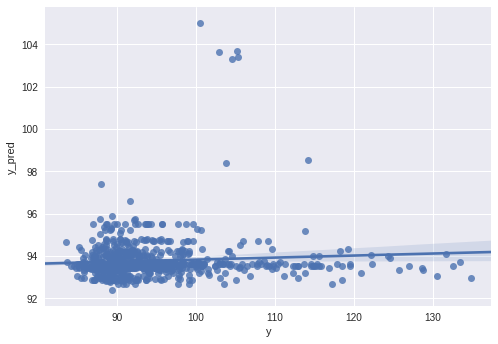

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.09817, std: 0.03749, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.11201, std: 0.03189, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.11232, std: 0.04440, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.07310, std: 0.04650, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.08321, std: 0.04288, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.08497, std: 0.04734, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.06556, std: 0.05257, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, '

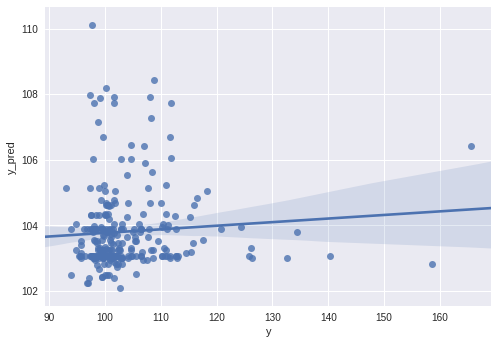

/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/kaggler/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.01658, std: 0.01689, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.01930, std: 0.01578, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.02299, std: 0.02220, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 2}, mean: -0.01177, std: 0.01479, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.01468, std: 0.01454, params: {'n_estimators': 70, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.01599, std: 0.01775, params: {'n_estimators': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, 'min_child_weight': 4}, mean: -0.01342, std: 0.01292, params: {'n_estimators': 60, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'max_depth': 1, '

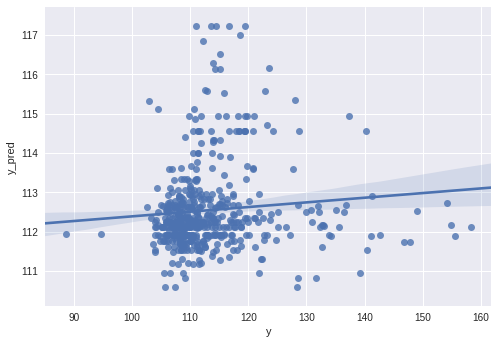

all:  0.592003009342


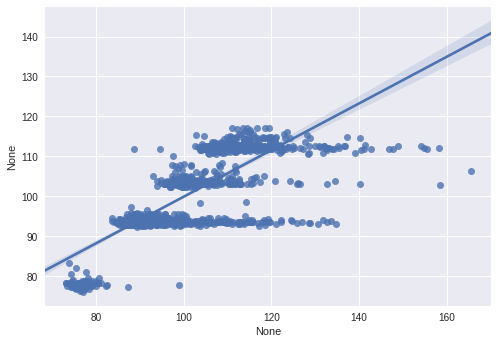

In [35]:
list_index = list(df_test_eng.columns.values)
li_remove = ['y']
for x in li_remove:
    list_index.remove(x)
list_test = list_index
list_train = ['y'] + list_test
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()

# list of parameters for each sub-set
cv_params_076 = {'max_depth': [1,2,3,4,5], 'learning_rate': [0.1], 'min_child_weight': [2,4,6,8], 'n_estimators': [60,70,80], 'colsample_bytree': [0.6,0.7,0.8]}
cv_params_090 = {'max_depth': [1,2,3,4,5], 'learning_rate': [0.1], 'min_child_weight': [2,4,6,8], 'n_estimators': [60,70,80], 'colsample_bytree': [0.6,0.7,0.8]}
cv_params_100 = {'max_depth': [1,2,3,4,5], 'learning_rate': [0.1], 'min_child_weight': [2,4,6,8], 'n_estimators': [60,70,80], 'colsample_bytree': [0.6,0.7,0.8]}
cv_params_107 = {'max_depth': [1,2,3,4,5], 'learning_rate': [0.1], 'min_child_weight': [2,4,6,8], 'n_estimators': [60,70,80], 'colsample_bytree': [0.6,0.7,0.8]}
ind_params_076 = {'seed':0, 'subsample': 0.8}
ind_params_090 = {'seed':0, 'subsample': 0.8}
ind_params_100 = {'seed':0, 'subsample': 0.8}
ind_params_107 = {'seed':0, 'subsample': 0.8}

cv_params = [cv_params_076, cv_params_090, cv_params_100, cv_params_107]
ind_params = [ind_params_076, ind_params_090, ind_params_100, ind_params_107]

for i in range(len(li_all_test)):
    df_X = li_all_train[i][list_train]
    df_Kaggle = li_all_test[i][list_test]
    df_y = df_X['y']
    df_X = df_X.drop('y', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.4, random_state=12345)    

    model = GridSearchCV(xgb.XGBRegressor(**ind_params[i]), cv_params[i], scoring = 'r2', cv = 4) 
    model.fit(X_train, y_train)
    print model.grid_scores_
    #print model.cv_results_
    best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
    print(score)
    for param_name in sorted(best_parameters.keys()):
        print("%s: %r" % (param_name, best_parameters[param_name]))
    y_pred = pd.Series(model.predict(X_test), name='y_pred', index=X_test.index)
    y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
    y_pred_all = y_pred_all.append(y_pred)
    y_test_all = y_test_all.append(y_test)
    df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
    y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
    print i, ': ', r2_score(y_test, y_pred)
    sns.regplot(y_test, y_pred)
    plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)

In [36]:
output_Kaggle.to_csv(path='../data/20170710.1011.xgboost.csv', index_label='ID', header = True)

In [45]:
df_eval = pd.concat([pd.DataFrame(y_test_all, columns=['test']), pd.DataFrame(y_pred_all, columns=['pred'])], axis=1)


In [46]:
df_eval.head(10)

,test,pred
2725,75.26,76.900177
8073,82.44,77.796753
3802,74.77,77.538826
4857,76.84,76.656143
3575,77.45,76.820366
5917,75.10,77.050339
824,77.31,78.732933
4110,77.16,78.262764
7851,77.11,77.486824
879,77.69,81.105225


In [49]:
df_eval['diff'] = abs(1 - df_eval['test'] / df_eval['pred'])

In [258]:
li_outliers = list(df_eval[(df_eval['diff'] > .1)].index.values)
#li_all_test = [df_test_eng_076, df_test_eng_090, df_test_eng_100, df_test_eng_107]
#li_all_train = [df_train_eng_076, df_train_eng_090, df_train_eng_100, df_train_eng_107]

In [259]:
df_train_eng_076_outl = df_train_eng_076[df_train_eng_076.index.isin(li_outliers)]
df_train_eng_090_outl = df_train_eng_090[df_train_eng_090.index.isin(li_outliers)]
df_train_eng_100_outl = df_train_eng_100[df_train_eng_100.index.isin(li_outliers)]
df_train_eng_107_outl = df_train_eng_107[df_train_eng_107.index.isin(li_outliers)]

In [260]:
df_train_eng_076_outl.shape

(3, 478)

In [261]:
df_train_eng_076_outl.head(5)

,X8_a,X8_b,X8_c,X8_d,X8_e,X8_f,X8_g,X8_h,X8_i,X8_j,...,X90,X91,X93,X94,X95,X96,X98,X99,qty_options,y
ID,,,,,,,,,,,,,,,,,,,,,
2149,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,56,87.31
6882,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,55,98.81
7153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,67,73.83


In [262]:
li_result = []
for df in [df_train_eng_076_outl, df_train_eng_090_outl, df_train_eng_100_outl, df_train_eng_107_outl]:
    list_index = df.mean(axis=0) < 0.00001
    li_result.append(list(df[list_index.index[list_index]].columns.values))
for i in range(len(li_result)):
    for a in li_result[i]:
        if df_train_eng[a].mean() > 0.85:
            print a, ', ', df_train_eng[a].mean(),
            for df in [df_train_eng_076_outl, df_train_eng_090_outl, df_train_eng_100_outl, df_train_eng_107_outl]:
                print df[a].mean(),
            print 'EOL'
    

X136 ,  0.956511406844 0.0 1.0 0.95 1.0 EOL
X189 ,  0.915399239544 0.0 1.0 0.95 0.9375 EOL
X238 ,  0.9161121673 0.0 1.0 1.0 0.875 EOL
X265 ,  0.905418250951 0.0 1.0 0.95 0.875 EOL


In [266]:
li_result = []
for df in [df_train_eng_076_outl, df_train_eng_090_outl, df_train_eng_100_outl, df_train_eng_107_outl]:
    list_index = df.mean(axis=0) > 0.999
    li_result.append(list(df[list_index.index[list_index]].columns.values))
for i in range(len(li_result)):
    for a in li_result[i]:
        if df_train_eng[a].mean() < 0.3:
            print a, ', ', df_train_eng[a].mean(),
            for df in [df_train_eng_076_outl, df_train_eng_090_outl, df_train_eng_100_outl, df_train_eng_107_outl]:
                print df[a].mean(),
            print 'EOL'


X3_f ,  0.255465779468 1.0 0.202247191011 0.5 0.208333333333 EOL
X0_az ,  0.0415874524715 1.0 0.0 0.0 0.0 EOL
X158 ,  0.229562737643 1.0 0.134831460674 0.35 0.166666666667 EOL
X162 ,  0.0408745247148 1.0 0.0 0.05 0.0 EOL
X166 ,  0.0332699619772 1.0 0.0 0.0 0.0 EOL
X232 ,  0.0430133079848 1.0 0.0 0.0 0.0 EOL
X272 ,  0.0375475285171 1.0 0.0 0.0 0.0 EOL
X276 ,  0.0384980988593 1.0 0.0 0.0 0.0 EOL
X29 ,  0.0430133079848 1.0 0.0 0.0 0.0 EOL
X328 ,  0.0401615969582 1.0 0.0 0.0 0.0 EOL
X378 ,  0.020674904943 1.0 0.0 0.0 0.0 EOL
X54 ,  0.0434885931559 1.0 0.0 0.05 0.0 EOL


In [232]:
for a in li_columns:
    if df_train_eng[a].mean() > 0.95:
        print a, ', ', df_train_eng[a].mean(),
        for df in [df_train_eng_076_outl, df_train_eng_090_outl, df_train_eng_100_outl, df_train_eng_107_outl]:
            print df[a].mean(),
        print 'EOL'

0 :  -0.528358203599


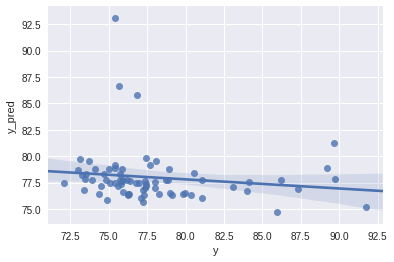

1 :  -0.0893503804771


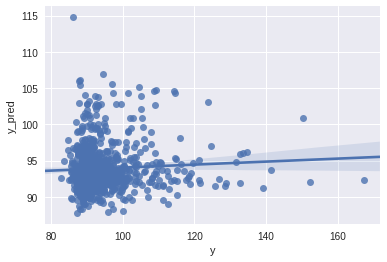

2 :  -0.0976652610081


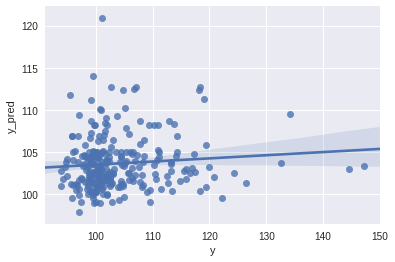

3 :  -0.187702641507


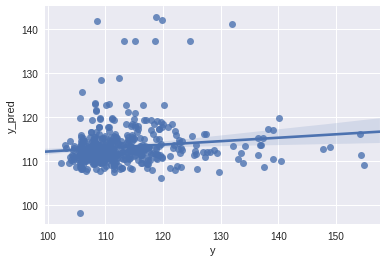

all:  0.510698337247


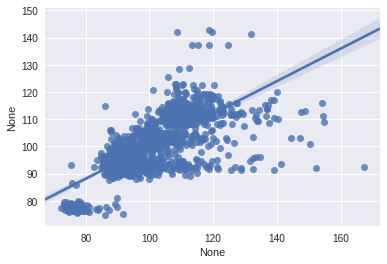

In [28]:
list_index = list(df_test_eng.columns.values)
li_remove = ['y']
for x in li_remove:
    list_index.remove(x)
list_test = list_index
list_train = ['y'] + list_test
df_pred = pd.DataFrame()
y_pred_all = pd.Series()
y_Kaggle_all = pd.Series()
y_test_all = pd.Series()
df_Kaggle_all = pd.DataFrame()

# list of parameters for each sub-set
cv_params_076 = {'max_depth': [1,2], 'learning_rate': [0.1], 'min_child_weight': [3,4,5], 'n_estimators': [48,50,52], 'colsample_bytree': [0.813, 0.815, 0.817]}
cv_params_090 = {'max_depth': [1,2], 'learning_rate': [0.1], 'min_child_weight': [6,7,8], 'n_estimators': [56,60,64], 'colsample_bytree': [0.656, 0.66, 0.664]}
cv_params_100 = {'max_depth': [1,2], 'learning_rate': [0.1], 'min_child_weight': [1,2,3], 'n_estimators': [68,70,72], 'colsample_bytree': [0.65, 0.655, 0.66]}
cv_params_107 = {'max_depth': [2,3,4], 'learning_rate': [0.1], 'min_child_weight': [6,7,8], 'n_estimators': [46,50,54], 'colsample_bytree': [0.646, 0.65, 0.654]}
ind_params_076 = {'seed':0, 'subsample': 0.8}
ind_params_090 = {'seed':0, 'subsample': 0.8}
ind_params_100 = {'seed':0, 'subsample': 0.8}
ind_params_107 = {'seed':0, 'subsample': 0.8}

cv_params = [cv_params_076, cv_params_090, cv_params_100, cv_params_107]
ind_params = [ind_params_076, ind_params_090, ind_params_100, ind_params_107]
rf_params = [110,600,320,400]

for i in range(len(li_all_test)):
    df_X = li_all_train[i][list_train]
    df_Kaggle = li_all_test[i][list_test]
    df_y = df_X['y']
    df_X = df_X.drop('y', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.4, random_state=0)    

    #model = GridSearchCV(xgb.XGBRegressor(**ind_params[i]), cv_params[i], scoring = 'r2', cv = 5) 
    model = RandomForestRegressor(n_estimators = rf_params[i])
    model.fit(X_train, y_train)
    #print model.grid_scores_
    #print model.cv_results_
    #best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
    #print(score)
    #for param_name in sorted(best_parameters.keys()):
    #    print("%s: %r" % (param_name, best_parameters[param_name]))
    y_pred = pd.Series(model.predict(X_test), name='y_pred', index=X_test.index)
    y_Kaggle = pd.Series(model.predict(df_Kaggle), name='y', index=df_Kaggle.index)
    y_pred_all = y_pred_all.append(y_pred)
    y_test_all = y_test_all.append(y_test)
    df_Kaggle_all = df_Kaggle_all.append(df_Kaggle)
    y_Kaggle_all = y_Kaggle_all.append(y_Kaggle)
    print i, ': ', r2_score(y_test, y_pred)
    sns.regplot(y_test, y_pred)
    plt.show()

print 'all: ', r2_score(y_test_all, y_pred_all)
sns.regplot(y_test_all, y_pred_all)
plt.show()

output_Kaggle = pd.Series(y_Kaggle_all, name='y', index=df_Kaggle_all.index)